<a id="A"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:10px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b>Oil Palm Image Classification</b></div>

In [1]:
# author: Tang Tiong Yew
# Oil Palm Image Classification IWAIT2025

<a id="A"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:90%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b>Import Libraries</b></div>

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import regularizers
import warnings
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

warnings.filterwarnings("ignore", category=UserWarning, message=r"Your `PyDataset` class should call `super().__init__\(\*\*kwargs\)`")

2024-11-26 10:06:59.167687: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-11-26 10:07:01.678645: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-11-26 10:07:01.680194: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-11-26 10:07:01.708139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-26 10:07:01.709423: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro P5000 computeCapability: 6.1
coreClock: 1.506GHz coreCount: 16 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 178.99GiB/s
2024-11-26 10:07:01.709455: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-11-26 10:07:01.756202: I tensorflow/stream_executor/platform/default/dso_

<a id="A"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:90%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b>Data Analyisis and Visualization</b></div>

In [4]:
df = pd.read_csv("/home/user/Desktop/IWAIT2025/IWAIT_Training_set.csv")
df.head(10)

,filename,label
0,frameterlalumasak6--38-_png.rf.9f7b1c287fa64b6...,overripe
1,frameterlalumasak6--25-_png.rf.508569371c5d683...,overripe
2,frameterlalumasak6--37-_png.rf.8924376317b052b...,overripe
3,frameterlalumasak4--40-_png.rf.ee35b791be703b4...,overripe
4,frameterlalumasak12--38-_png.rf.54718370ab9ea1...,overripe
5,frameterlalumasak4--1-_png.rf.8779f9bd9d427e90...,overripe
6,frameterlalumasak7--33-_png.rf.3e127961bdfc61f...,overripe
7,frameterlalumasak10--43-_png.rf.a47db166f88135...,overripe
8,frameterlalumasak13--41-_png.rf.4ade8c205c608e...,overripe
9,frameterlalumasak13--23-_png.rf.d7dfde17710959...,overripe


In [5]:
len(df)

3557

/tmp/ipykernel_4730/912473878.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


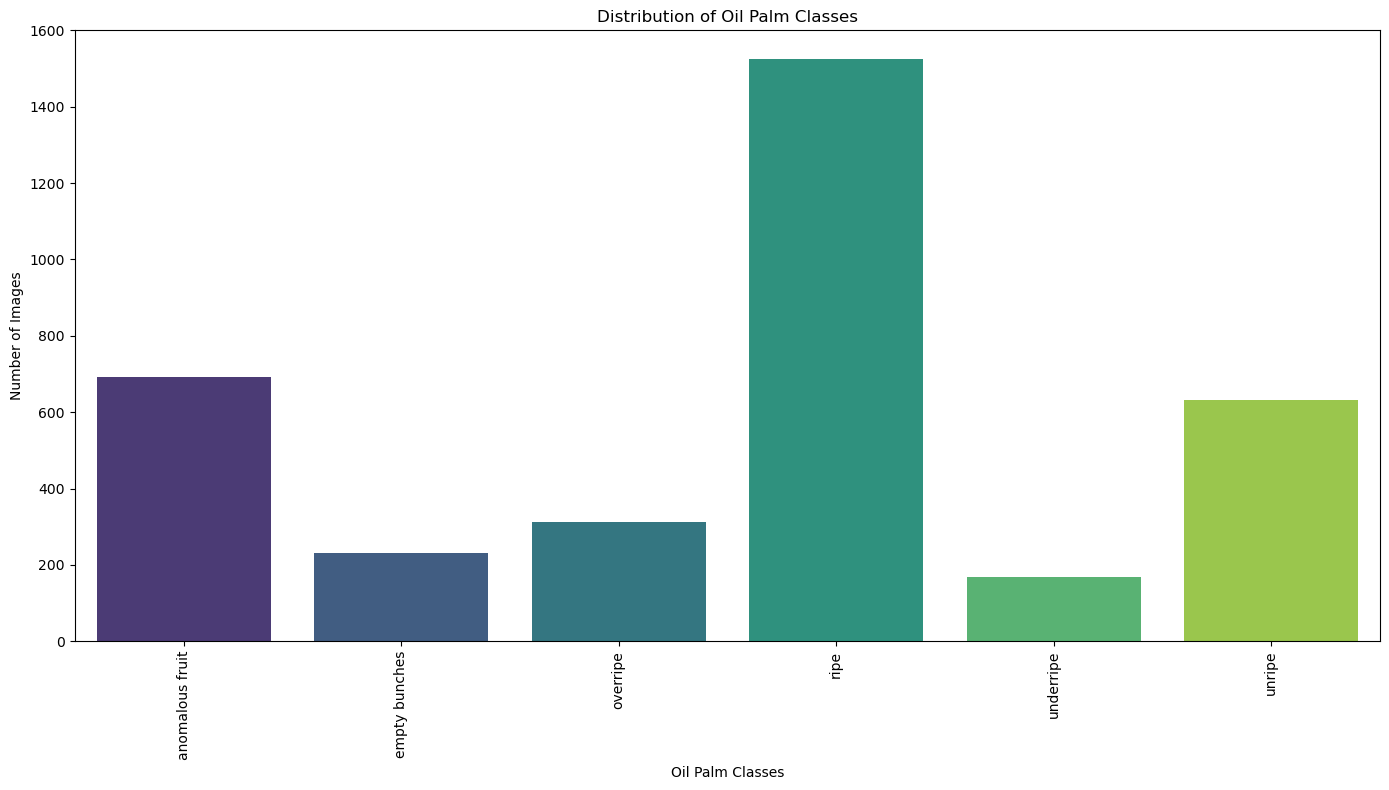

In [6]:
class_counts = df['label'].value_counts().sort_index()

plt.figure(figsize=(14, 8))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribution of Oil Palm Classes')
plt.xlabel('Oil Palm Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

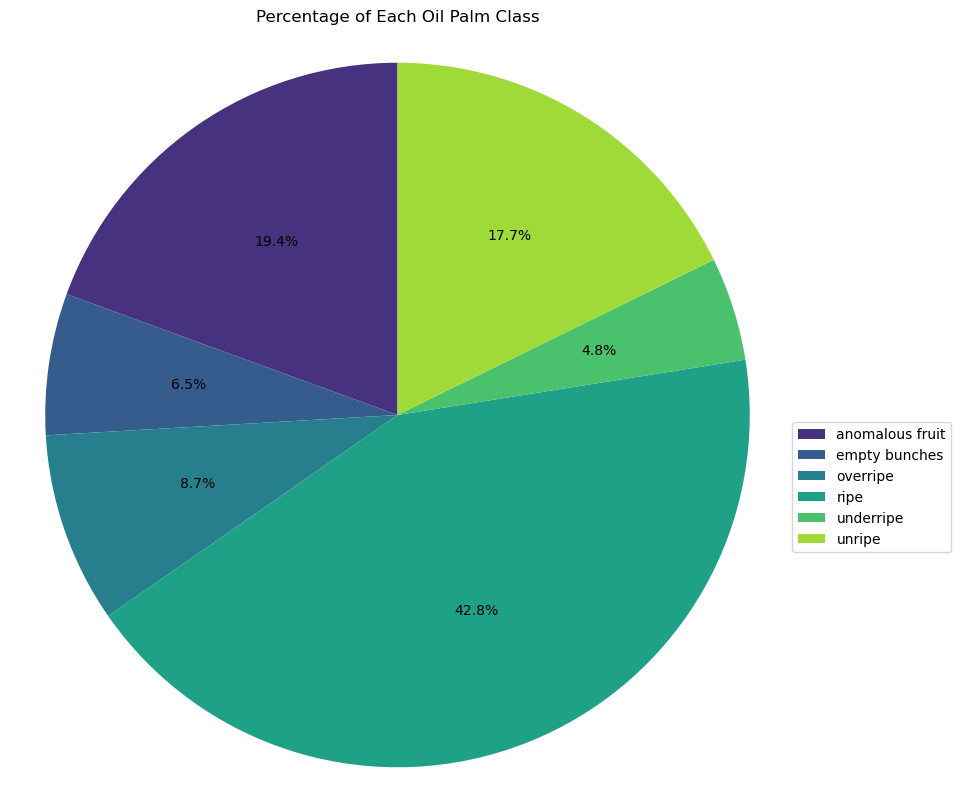

In [7]:
colors = sns.color_palette("viridis", len(class_counts))
class_counts = df['label'].value_counts().sort_index()


plt.figure(figsize=(10, 10))
plt.pie(class_counts.values, labels=None, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage of Each Oil Palm Class')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(class_counts.index, loc="best", bbox_to_anchor=(1, 0.5))
plt.show()

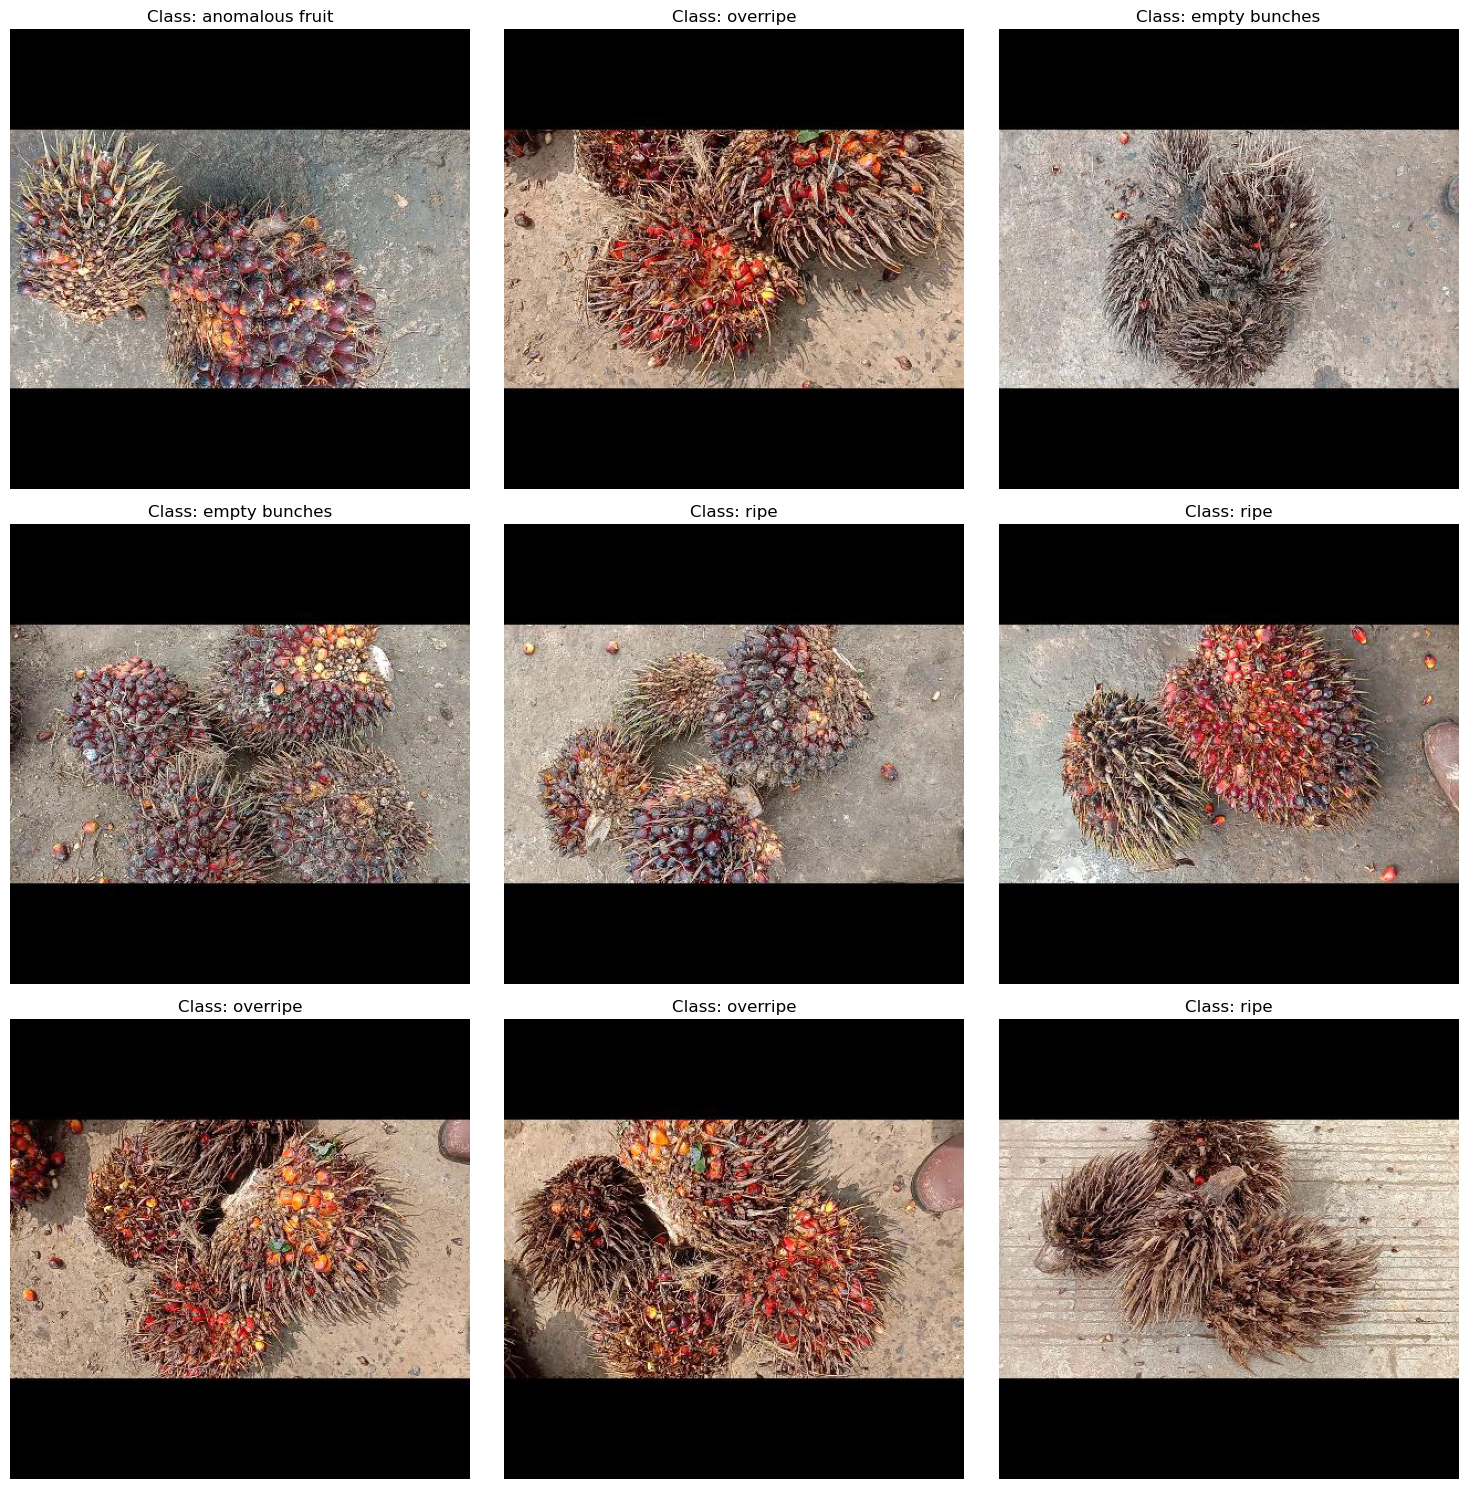

In [8]:
image_dir = "/home/user/Desktop/IWAIT2025/Oil Palm Datasets/train_rev2/train"

sample_images = df.sample(9, random_state=42)


fig, axes = plt.subplots(3, 3, figsize=(15, 15))


for i, (index, row) in enumerate(sample_images.iterrows()):
    img_path = os.path.join(image_dir, row['filename'])
    img = load_img(img_path, target_size=(416, 416))
    img_array = img_to_array(img) / 255.0  # Normalize the image
    
    ax = axes[i // 3, i % 3]
    ax.imshow(img_array)
    ax.set_title(f"Class: {row['label']}")
    ax.axis('off')

plt.tight_layout()
plt.show()

<a id="A"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:90%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b>Splitting Dataset</b></div>

In [9]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

image_dir = "/home/user/Desktop/IWAIT2025/Oil Palm Datasets/train_rev2/train"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(416, 416),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(416, 416),
    batch_size=32,
    class_mode='categorical'
)

Found 2845 validated image filenames belonging to 6 classes.
Found 712 validated image filenames belonging to 6 classes.


<a id="A"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:90%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b>Building the Model</b></div>

In [10]:
model_CNN = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(416, 416, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(6, activation='softmax')
])


model_CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model_CNN.summary()

2024-11-26 10:07:03.738020: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 10:07:03.738691: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-11-26 10:07:03.738970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-26 10:07:03.740247: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro P5000 computeCapability: 6.1
coreClock: 1.506GHz coreCount: 16 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 178.99GiB/s
2024-

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 414, 414, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 207, 207, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 205, 205, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 102, 102, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 320000)            0

In [11]:
history = model_CNN.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    epochs = 200,
    validation_data = val_generator,
    validation_steps = val_generator.samples // val_generator.batch_size
)

2024-11-26 10:07:06.870348: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 66453504 exceeds 10% of free system memory.
2024-11-26 10:07:06.994064: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-11-26 10:07:06.997047: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz


Epoch 1/200


2024-11-26 10:07:07.403619: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-11-26 10:07:08.510949: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 66453504 exceeds 10% of free system memory.
2024-11-26 10:07:08.619320: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-11-26 10:07:09.917480: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 66453504 exceeds 10% of free system memory.
2024-11-26 10:07:10.274588: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2024-11-26 10:07:10.324075: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


 2/88 [..............................] - ETA: 19s - loss: 24.2164 - accuracy: 0.4531 

2024-11-26 10:07:18.152544: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 66453504 exceeds 10% of free system memory.


 3/88 [>.............................] - ETA: 57s - loss: 27.4270 - accuracy: 0.4306

2024-11-26 10:07:19.202843: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 66453504 exceeds 10% of free system memory.


88/88 [==============================] - ETA: 0s - loss: 7.0032 - accuracy: 0.3656

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fadd15cf1c0>>
Traceback (most recent call last):
  File "/home/user/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



<a id="A"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:90%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b>Evaluating the Model</b></div>

In [ ]:
val_images, val_labels = next(val_generator)

pred_labels = model_CNN.predict(val_images)
pred_labels = np.argmax(pred_labels, axis=1)
true_labels = np.argmax(val_labels, axis=1)

class_indices = val_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

def display_images(images, true_labels, pred_labels, class_names, num_images=9):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        true_label = class_names[int(true_labels[i])]
        pred_label = class_names[int(pred_labels[i])]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_images(val_images, true_labels, pred_labels, class_names, num_images=9)

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
model_CNN.save("oil_palm_classification_model.keras")

In [ ]:
df_test = pd.read_csv("/home/user/Desktop/IWAIT2025/IWAIT_Testing_set.csv")
test_image_dir = "/home/user/Desktop/IWAIT2025/Oil Palm Datasets/test_rev2/test"
test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=test_image_dir,
    x_col='filename',
    y_col='label',
    target_size=(416, 416),
    batch_size=397,
    class_mode='categorical'
)

test_images, test_labels = next(test_generator)

In [ ]:
pred_labels = tf.argmax(model_CNN.predict(test_images), axis=1)
pred_labels

test_caption = df_test['label_num']
print("F1_Score macro:",f1_score(test_caption, pred_labels, average='macro'))
print("F1_Score: micro",f1_score(test_caption, pred_labels, average='micro'))
print("F1_Score weighted:",f1_score(test_caption, pred_labels, average='weighted'))
print("F1_Score:",f1_score(test_caption, pred_labels, average=None))

print("accuracy_score normalize false:",accuracy_score(test_caption, pred_labels, normalize=False))
print("accuracy_score:",accuracy_score(test_caption, pred_labels ))

print("precision_score macro:",precision_score(test_caption, pred_labels,  average='macro'))
print("precision_score micro:",precision_score(test_caption, pred_labels, average='micro'))
print("precision_score weighted:",precision_score(test_caption, pred_labels, average='weighted'))
print("precision_score for each class:",precision_score(test_caption, pred_labels, average=None))

print("recall_score macro:",recall_score(test_caption, pred_labels, average='macro'))
print("recall_score micro:",recall_score(test_caption, pred_labels, average='micro'))
print("recall_score weighted:",recall_score(test_caption, pred_labels, average='weighted'))
print("recall_score for each class:",recall_score(test_caption, pred_labels, average=None))

<a id="A"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:90%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b>Conclusion</b></div>

In [ ]:
test_caption = df_test['label_num']
print("F1_Score macro:",f1_score(test_caption, pred_labels, average='macro'))
print("F1_Score: micro",f1_score(test_caption, pred_labels, average='micro'))
print("F1_Score weighted:",f1_score(test_caption, pred_labels, average='weighted'))
print("F1_Score:",f1_score(test_caption, pred_labels, average=None))

print("accuracy_score normalize false:",accuracy_score(test_caption, pred_labels, normalize=False))
print("accuracy_score:",accuracy_score(test_caption, pred_labels ))

print("precision_score macro:",precision_score(test_caption, pred_labels,  average='macro'))
print("precision_score micro:",precision_score(test_caption, pred_labels, average='micro'))
print("precision_score weighted:",precision_score(test_caption, pred_labels, average='weighted'))
print("precision_score for each class:",precision_score(test_caption, pred_labels, average=None))

print("recall_score macro:",recall_score(test_caption, pred_labels, average='macro'))
print("recall_score micro:",recall_score(test_caption, pred_labels, average='micro'))
print("recall_score weighted:",recall_score(test_caption, pred_labels, average='weighted'))
print("recall_score for each class:",recall_score(test_caption, pred_labels, average=None))



In [ ]:
paths = [''] * 8   # list of 8 element
paths[0] = '/home/user/Desktop/IWAIT2025/Oil Palm Datasets/noisy_test_10'
paths[1] = '/home/user/Desktop/IWAIT2025/Oil Palm Datasets/noisy_test_20'
paths[2] = '/home/user/Desktop/IWAIT2025/Oil Palm Datasets/noisy_test_30'
paths[3] = '/home/user/Desktop/IWAIT2025/Oil Palm Datasets/noisy_test_40'
paths[4] = '/home/user/Desktop/IWAIT2025/Oil Palm Datasets/noisy_test_50'
paths[5] = '/home/user/Desktop/IWAIT2025/Oil Palm Datasets/noisy_test_60'
paths[6] = '/home/user/Desktop/IWAIT2025/Oil Palm Datasets/noisy_test_70'
paths[7] = '/home/user/Desktop/IWAIT2025/Oil Palm Datasets/noisy_test_80'


for p in paths:
    df_test = pd.read_csv("/home/user/Desktop/IWAIT2025/noisy_IWAIT_Testing_set.csv")
    test_image_dir = p
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=test_image_dir,
        x_col='filename',
        y_col='label',
        target_size=(416, 416),
        batch_size=397,
        class_mode='categorical'
    )
    
    test_images, test_labels = next(test_generator)
    pred_labels = tf.argmax(model_CNN.predict(test_images), axis=1)
    pred_labels
    test_caption = df_test['label_num']
    print(p)
    print("F1_Score macro:",f1_score(test_caption, pred_labels, average='macro'))
    print("F1_Score: micro",f1_score(test_caption, pred_labels, average='micro'))
    print("F1_Score weighted:",f1_score(test_caption, pred_labels, average='weighted'))
    print("F1_Score:",f1_score(test_caption, pred_labels, average=None))
    
    print("accuracy_score normalize false:",accuracy_score(test_caption, pred_labels, normalize=False))
    print("accuracy_score:",accuracy_score(test_caption, pred_labels ))
    
    print("precision_score macro:",precision_score(test_caption, pred_labels,  average='macro'))
    print("precision_score micro:",precision_score(test_caption, pred_labels, average='micro'))
    print("precision_score weighted:",precision_score(test_caption, pred_labels, average='weighted'))
    print("precision_score for each class:",precision_score(test_caption, pred_labels, average=None))
    
    print("recall_score macro:",recall_score(test_caption, pred_labels, average='macro'))
    print("recall_score micro:",recall_score(test_caption, pred_labels, average='micro'))
    print("recall_score weighted:",recall_score(test_caption, pred_labels, average='weighted'))
    print("recall_score for each class:",recall_score(test_caption, pred_labels, average=None))
